In [1]:
import pathlib as pl
import numpy as np
import modflowapi
import swiapi
import flopy

# path to mf6 shared library
# executables based on mf6 feat-swi branch at: 
#   https://github.com/langevin-usgs/modflow6/tree/feat-swi
mf6exe = "/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6"
libmf6 = "/Users/langevin/langevin/dev/modflow6-fork.git/bin/libmf6.dylib"


## Create and Run Simple Test Model

In [2]:
#create simple test model
Lx = 10000 # meters
delr, delc = 100., 1.
ncol = int(Lx / delr)
nlay = 1
nrow = 1
top = 50.
botm = -400.
recharge = 0.001
k = 10.
h0 = 0.
h1 = h0
icelltype = 1

ws = './mymodel'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(
    sim_name=name, 
    sim_ws=ws, 
    exe_name=mf6exe,
    memory_print_option="all"
)
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_specific_discharge=True,
    alternative_cell_averaging="harmonic",
    icelltype=icelltype,
    k=k,
)
swi = flopy.mf6.ModflowGwfswi(gwf, zeta=botm)
cghb = 1. * delr * delc / 10.
ghb = flopy.mf6.ModflowGwfghb(gwf, stress_period_data=[[0, 0, 0, h0, cghb],
                                                       [0, 0, ncol - 1, h1, cghb]])
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=budget_file,
        head_filerecord=head_file,
        saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
        printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
)
sim.write_simulation()
#sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package swi...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 2 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...


In [3]:
# head = gwf.output.head().get_data()
# bud = gwf.output.budget()
# print(head.flatten())

# spdis = bud.get_data(text='DATA-SPDIS')[0]
# qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
# pxs = flopy.plot.PlotCrossSection(gwf, line={"row":0})
# pxs.plot_grid()
# pxs.plot_bc("ghb")
# pxs.plot_vector(qx, qy, qz, normalize=True, color="black")

## Run Example Using API

### Run Model by Time Step

In [4]:
# mf6 =  modflowapi.ModflowApi(libmf6, working_directory=ws)
# print("Initializing mf6...")
# mf6.initialize()
# current_time = 0.
# end_time = mf6.get_end_time()

# while current_time < end_time:
#     print("  Updating mf6...")
#     mf6.update()
#     current_time = mf6.get_current_time()

# print ("Finalizing mf6...")
# mf6.finalize()

### Run Model By Iteration

In [5]:
mf6 =  modflowapi.ModflowApi(libmf6, working_directory=ws)
swiapi = swiapi.SwiAPi(mf6, name)
print("Initializing mf6...")
mf6.initialize()

swiapi.create_pointers()
# swiapi.print_pointers()

current_time = 0.
end_time = mf6.get_end_time()

# update zeta using the initial head
swiapi.update_zeta()

while current_time < end_time:
    
    print("  Get and prepare time step...")
    dt = mf6.get_time_step()
    mf6.prepare_time_step(dt)
    
    kiter = 0
    print("  Prepare solve...")
    mf6.prepare_solve(1)
    while kiter < 30:

        print(f"\n    Solve...(kiter={kiter})")
        swiapi.formulate(dt)
        has_converged = mf6.solve(1)

        # update zeta using the recent head iterate
        swiapi.update_zeta()

        if has_converged:
            break
        kiter += 1

        # swiapi.print_pointers()

    print("  Finalize solve...")
    mf6.finalize_solve(1)
    
    print("  Finalize time step...")
    mf6.finalize_time_step()
    current_time = mf6.get_current_time()

print ("Finalizing mf6...")
mf6.finalize()

Initializing mf6...
Accessing pointer using tag: MYMODEL/INSTO
Accessing pointer using tag: MYMODEL/ISS
Accessing pointer using tag: MYMODEL/X
Accessing pointer using tag: MYMODEL/XOLD
Accessing pointer using tag: MYMODEL/RHS
Accessing pointer using tag: SLN_1/IA
Accessing pointer using tag: SLN_1/JA
Accessing pointer using tag: SLN_1/AMAT
Accessing pointer using tag: MYMODEL/DIS/AREA
Accessing pointer using tag: MYMODEL/DIS/TOP
Accessing pointer using tag: MYMODEL/DIS/BOT
Accessing pointer using tag: MYMODEL/NPF/SAT
Accessing pointer using tag: MYMODEL/NPF/CONDSAT
Accessing pointer using tag: MYMODEL/SWI/ZETA
Accessing pointer using tag: MYMODEL/SWI/HCOF
Accessing pointer using tag: MYMODEL/SWI/RHS
  Get and prepare time step...
  Prepare solve...

    Solve...(kiter=0)

    Solve...(kiter=1)

    Solve...(kiter=2)

    Solve...(kiter=3)

    Solve...(kiter=4)

    Solve...(kiter=5)

    Solve...(kiter=6)

    Solve...(kiter=7)

    Solve...(kiter=8)
  Finalize solve...
  Finalize tim

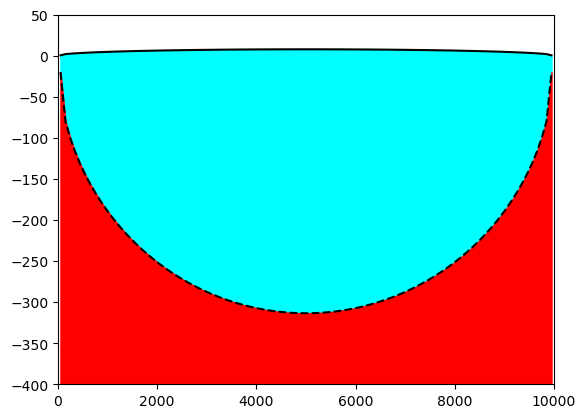

In [6]:
zeta = swiapi.zeta_last
x = gwf.modelgrid.xcellcenters.flatten()
head = gwf.output.head().get_data().flatten()
bud = gwf.output.budget()
#print(head.flatten())
#print(zeta.flatten())

spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
pxs = flopy.plot.PlotCrossSection(gwf, line={"row":0})
ax = pxs.ax
if ncol < 50:
    pxs.plot_grid()
#pxs.plot_bc("ghb")
ax.plot(x, head, "k-")
ax.plot(x, zeta, "k--")
# freshwater
ax.fill_between(x, head, zeta, color="cyan")
# saltwater
ax.fill_between(x, zeta, botm, color="red")
# pxs.plot_vector(qx, qy, qz, normalize=True, color="black")

In [7]:
fpth = pl.Path(ws) / f"{name}.dis.grb"
grb = flopy.mf6.utils.MfGrdFile(fpth)
ia = grb.ia
ja = grb.ja
nodes = grb.nodes
flowja = bud.get_data(text="FLOW-JA-FACE")[0].flatten()

# print flows bewteen cells
# for n in range(nodes):
#     for ipos in range(ia[n] + 1, ia[n + 1]):
#         m = ja[ipos]
#         q = flowja[ipos]
#         if m > n:
#             print(f"{n=} {m=} {q=}")